In [1]:
import torch
import pandas as pd
import numpy as np
import random

from torch.nn.functional import tanh
from torch.nn.functional import softmax
import torch.nn.functional as F

In [2]:
tempDf = pd.read_csv('Dataset-Indian-Names-master/Indian-Male-Names.csv')
namesList = tempDf['name'][tempDf['name'].notna()].tolist()
tempDf = pd.read_csv('Dataset-Indian-Names-master/Indian-Female-Names.csv')
namesList.extend(tempDf['name'][tempDf['name'].notna()].tolist())

In [3]:
namesList = open('Dataset-Indian-Names-master/names.txt', 'r').read().splitlines()

In [4]:
uniqueChar = set()
for name in namesList:
        for char in name:
            uniqueChar.add(char)


In [5]:
startChar = '<S>'
endChar = '<E>'
uniqueChar.add(startChar)
uniqueChar.add(endChar)
print(f'Total names :- {len(namesList)}')
print(f'Total unique characters :- {len(uniqueChar)}')

Total names :- 32033
Total unique characters :- 28


In [6]:
torch.randn(2)

tensor([ 2.2757, -0.8100])

## Prepare char sequences

In [13]:
sequence_size = 3
all_sequences = []
for name in namesList:
    sequence = []
    for i in range(sequence_size+1):
        sequence += [startChar]
    for i in range(len(name)+1):
        if i == len(name):
            char = '<E>'
        else:
            char = name[i]
        sequence = sequence[1:] + [char]
        all_sequences.append(sequence)

In [14]:
charEmbeddingSize = 2
embeddingLookUp = {}
charToIdxMap = {}
idxToCharMap = {}
idx = 0

for char in uniqueChar:
    embeddingLookUp[char] = torch.randn(charEmbeddingSize)
    charToIdxMap[char] = idx
    idxToCharMap[idx] = char
    idx+=1
    
one_hot_encoded = torch.eye(len(uniqueChar))
layer_size = 100
W1 = torch.randn(charEmbeddingSize * sequence_size, layer_size)
b1 = torch.randn(layer_size)

W2 = torch.randn(layer_size, len(uniqueChar))
b2 = torch.randn(len(uniqueChar))

In [15]:
def generate_batch(dataset, batch_size):
    while True:
        random.shuffle(dataset)
        for i in range(0, len(dataset), batch_size):
            yield dataset[i: i+batch_size]
            

In [16]:
# Prepare list of parameters

# Embeddings, W1, b1, W2, b2
parameters = [W1, W2, b1, b2]

for key in embeddingLookUp:
    parameters.append(embeddingLookUp[key])

# Make sure to set 
for p in parameters:
    p.requires_grad = True
print(len(parameters))
lossArr = []

32


In [17]:
## Try training against embedding

num_iterations = 200000
batch_size = 32
lr = 0.01
idx = 0
batch_generator = generate_batch(all_sequences, batch_size)
for i in range(num_iterations):
    idx += 1
    loss = None
    for p in parameters:
        p.grad = None
    batch = next(batch_generator)
    X = []
    Y = []
    for row in batch:
        sequence = row[:-1]
        y = row[-1]
        input_tensor = []
        for char in sequence:
            input_tensor.append(embeddingLookUp[char])
        target = one_hot_encoded[charToIdxMap[y]]
        X.append(torch.cat(input_tensor))
        Y.append(target)
    # print(len(X))
    # print(X[0])
    # print(Y[0])
    X = torch.stack(X)
    Y = torch.stack(Y)
    # print(X.shape)
    # print(W1.shape)
    # break
    layerOut = tanh(X @ W1 + b1)
    out = layerOut @ W2 + b2
    
    
    #Calculate loss
    loss = F.cross_entropy(out, Y)
    lossArr.append(loss.log10().item())
    if idx%10000 == 0:
        print(idx)
        print(np.mean(lossArr[-1000:]))
    # break
    loss.backward()
    
    for p in parameters:
        if p.grad is not None:
            p.data -= lr * p.grad
            
    


10000
0.40744667223095893
20000
0.3929899191558361
30000
0.3892027229964733
40000
0.3847204420864582
50000
0.38337207382917404
60000
0.3812963389456272
70000
0.3781218470782042
80000
0.3765225687623024
90000
0.3758898879289627
100000
0.3765432702898979
110000
0.3745800365805626
120000
0.3732610098272562
130000
0.3707255246192217
140000
0.37250972309708597
150000
0.37259193961322307
160000
0.37127669927477835
170000
0.37158430136740206
180000
0.3683952831178904
190000
0.37026107209920883
200000
0.37132302221655844


In [18]:
import matplotlib.pyplot as plt

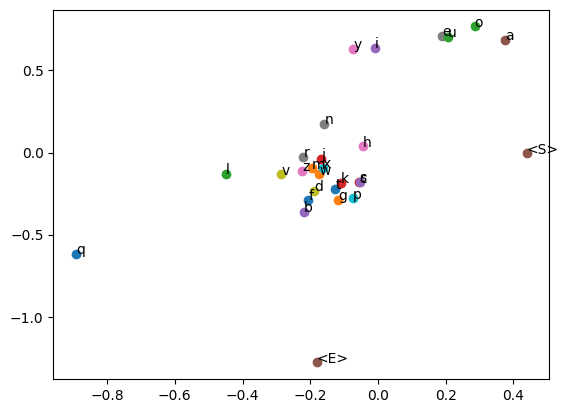

In [19]:
for char in embeddingLookUp:
    if char.isascii() is not True:
        continue
    embedding = embeddingLookUp[char].detach().numpy()
    plt.scatter(embedding[0], embedding[1])
    plt.annotate(char, (embedding[0], embedding[1]))

In [17]:
'<E>'.isascii()

True